In [1]:
%reload_ext autoreload
%autoreload
%matplotlib inline

In [2]:
from fastai.text import *

In [83]:
# torch.cuda.empty_cache()

In [3]:
path = Path()
path.ls()

[PosixPath('ttat.csv'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('tr_ch_tw_train.csv'),
 PosixPath('data_lm_export.pkl'),
 PosixPath('Senators'),
 PosixPath('final_china - output.csv'),
 PosixPath('Trump on Trade.ipynb'),
 PosixPath('Reps'),
 PosixPath('all_congress_tweets.csv'),
 PosixPath('models'),
 PosixPath('Tweets Descriptive Stats.ipynb'),
 PosixPath('data_clas_export.pkl'),
 PosixPath('US Congress on China and Trade.ipynb'),
 PosixPath('allsenatorsandrepsoutput.csv')]

# Sentiment Model on China Using ULMFIT and Trump Tweets

In [11]:
df = pd.read_csv('ttat.csv',error_bad_lines=False)
df.head()

,sentiment,text,retweet_count
0,NaN,RT @ChatByCC: Strong people stand up for thems...,20709
1,NaN,The Media has a big responsibility to life and...,4749
2,NaN,We cannot let those killed in El Paso Texas an...,4687
3,NaN,....this legislation with desperately needed i...,4069
4,NaN,Today I authorized the lowering of the flags t...,20958


In [12]:
df.shape

(36989, 3)

In [13]:
bs=64

In [14]:
#Language Model DataBunch
data_lm = TextLMDataBunch.from_csv(path, 'ttat.csv', max_vocab=60000, min_freq=1)

In [15]:
data_lm.vocab.itos[:5]

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld']

In [16]:
data_lm.show_batch(3)

idx,text
0,xxmaj shows how hard u will work for us as xxmaj president xxbos xxmaj thanks @mickyarison for your nice statement @bltprimemiami @trumpdoral . i just want to do as well as you have with @miamiheat . xxmaj see u soon xxbos â€œgood communicators control space.â€ â€ “ xxmaj roger xxmaj ailes â€˜you xxmaj are xxmaj the xxmaj messageâ€ ™ @foxnews xxbos xxmaj please clear up the xxmaj fake xxmaj news
1,xxmaj new xxmaj gravis xxmaj poll in xxup nh just out : xxmaj trump 32 % xxmaj carson 13 % http : / / t.co / mjcwoeijkv xxbos @willise2n : @realdonaldtrump u r a hero to us in xxmaj nigeria / xxmaj africa . xxmaj wen r u visiting us nxt ? xxmaj it wld be a dream come true to meet xxmaj really nice xxbos xxmaj trump xxmaj was
2,/ / t.co / xymia0az7x xxbos @nypost : xxmaj people are writing tribute songs for xxmaj donald xxmaj trump http : / / t.co / yepsqfmbgy xxmaj thanks to all of these great songwriters . xxmaj get rich ! xxbos xxmaj congratulations to xxmaj boston on the @redsox xxmaj world xxmaj series victory . xxmaj earned and deserved . xxbos â€œaction is the foundational key to all success.â€ - xxmaj


In [17]:
# Classifier DataBunch
data_clas = TextClasDataBunch.from_csv(path, 'tr_ch_tw_train.csv', vocab=data_lm.train_ds.vocab, bs=8)

In [18]:
#Save both DataBunches
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

### Language Model

In [19]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                if N_sma > 5:                    
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                if N_sma > 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad, use_variance=True, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss

In [24]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, opt_func=RAdam)

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


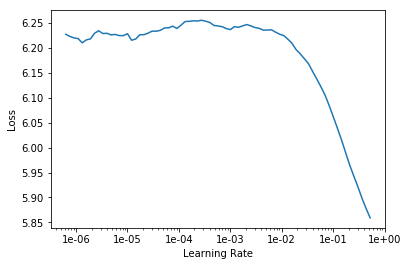

In [26]:
learn.recorder.plot(skip_end=15)

In [27]:
# Run one epoch with lower layers 
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.386556,3.861226,0.340306,01:17


In [28]:
# Run for many epochs with all layers unfrozen
learn.unfreeze()
learn.fit_one_cycle(10, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.794341,3.637091,0.373606,01:30
1,3.855930,3.792387,0.361366,01:30
2,3.948900,4.012999,0.341245,01:30
3,3.995322,4.060075,0.337236,01:30
4,3.906640,4.076815,0.338826,01:30
5,3.752606,4.003044,0.349868,01:30
6,3.512809,3.964570,0.358414,01:30
7,3.257767,3.938912,0.366299,01:30
8,2.973119,3.969846,0.369547,01:30
9,2.766482,4.009140,0.369502,01:30


In [29]:
learn.save_encoder('ft_enc')

### The Classifier

In [22]:
# #reload Databunches and Encoder
# data_lm = load_data(path, 'data_lm_export.pkl')
# data_clas = load_data(path, 'data_clas_export.pkl')

In [23]:
# load_encoder('ft_enc')

NameError: name 'load_encoder' is not defined

In [30]:
bs=8

In [39]:
# Classifier Learner Object
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.9) #opt_func=RAdam, 

In [40]:
learn.load_encoder('ft_enc')

In [34]:
data_clas.show_batch()

text,target
xxbos xxmaj there will be nobody left in xxmaj china to do business with . xxmaj very bad for xxmaj china very good for xxup usa ! xxmaj but xxmaj china has taken so advantage of the xxup u.s. for so many years that they are way ahead ( xxmaj our xxmaj presidents did not do the job ) . xxmaj therefore xxmaj china should not retaliate - will only,negative
xxbos xxmaj china must continue to be strong and tight on the xxmaj border of xxmaj north xxmaj korea until a deal is made . xxmaj the word is that recently the xxmaj border has become much more porous and more has been filtering in . i want this to happen and xxmaj north xxmaj korea to be xxup very successful but only after signing !,positive
xxbos xxmaj very productive talks yesterday with xxmaj china on xxmaj trade . xxmaj will continue today ! i will be leaving for xxmaj hanoi xxmaj vietnam early tomorrow for a xxmaj summit with xxmaj kim xxmaj jong xxmaj un of xxmaj north xxmaj korea where we both expect a continuation of the progress made at first xxmaj summit in xxmaj singapore . xxmaj denuclearization ?,positive
xxbos xxmaj just had a long and very good conversation with xxmaj president xxmaj xi xxmaj jinping of xxmaj china . xxmaj we talked about many subjects with a heavy emphasis on xxmaj trade . xxmaj those discussions are moving along nicely with meetings being scheduled at the xxup g-20 in xxmaj argentina . xxmaj also had good discussion on xxmaj north xxmaj korea !,positive
xxbos xxmaj china is subsidizing its product in order that it can continue to be sold in the xxup usa . xxmaj many firms are leaving xxmaj china for other countries including the xxmaj united xxmaj states in order to avoid paying the xxmaj tariffs . xxmaj no visible increase in costs or inflation but xxup u.s. is taking in xxmaj billions !,negative


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


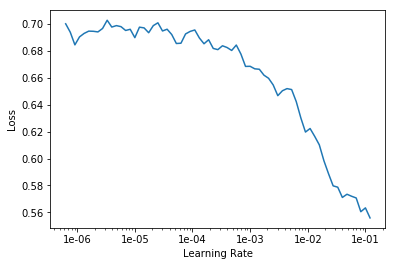

In [41]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [42]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.538204,0.648798,0.619048,00:00


In [43]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.537653,0.507764,0.761905,00:00


In [44]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.434813,0.473632,0.761905,00:01


In [46]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-2/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.406944,0.360775,0.857143,00:01
1,0.402414,0.347231,0.857143,00:01
2,0.389133,0.348255,0.857143,00:01
3,0.394428,0.331793,0.904762,00:01
4,0.376054,0.337859,0.857143,00:01
5,0.348756,0.355085,0.857143,00:01
6,0.342362,0.338766,0.904762,00:01
7,0.339284,0.340425,0.904762,00:01
8,0.346276,0.337076,0.904762,00:01
9,0.347608,0.342713,0.857143,00:01


# Preparing the Test Data

In [47]:
test = pd.read_csv(path/'all_congress_tweets.csv')
test.head(5)

,sentiment,Tweets,Likes,RTs,chamber,party
0,NaN,by adopting russian disinformation tactics dep...,535,173,house,democrats
1,NaN,the u.s. cannot lose its voice when human righ...,4553,997,house,democrats
2,NaN,the people of hong kong deserve to have their ...,363,80,house,democrats
3,NaN,words of world leaders can have dangerous cons...,4102,1376,house,democrats
4,NaN,"unfortunately, president trump has not only ce...",3524,922,house,democrats


In [ ]:
#change column width
# pd.options.display.max_colwidth = 50
# delete column
# df = df.drop("Unnamed: 0", axis=1)

In [48]:
test_pred = test

In [49]:
test_pred['sentiment'] = test_pred['Tweets'].apply(lambda row: str(learn.predict(row)[0]))
test_pred.head(40)

,sentiment,Tweets,Likes,RTs,chamber,party
0,negative,by adopting russian disinformation tactics dep...,535,173,house,democrats
1,negative,the u.s. cannot lose its voice when human righ...,4553,997,house,democrats
2,negative,the people of hong kong deserve to have their ...,363,80,house,democrats
3,negative,words of world leaders can have dangerous cons...,4102,1376,house,democrats
4,negative,"unfortunately, president trump has not only ce...",3524,922,house,democrats
5,negative,the ongoing trade war with china not only hurt...,46,16,house,democrats
6,positive,this directly hurts farmers in my district. as...,15,8,house,democrats
7,negative,soybean growers in tell me over over that they...,27,14,house,democrats
8,negative,"tomorrow, yet another round of retaliatory tar...",39,15,house,democrats
9,negative,☑️require the administration to develop an unc...,5,2,house,democrats


In [50]:
test_pred.shape

(4966, 6)

In [51]:
test_pred.to_csv('allsenatorsandrepsoutput.csv')

# # Sentiment Model on China Using BERT

Source: https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/

In [4]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
# class FastAiBertTokenizer(BaseTokenizer):
#  '''Wrapper around BertTokenizer to be compatible with fast.ai'''
#  def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
#         self._pretrained_tokenizer = tokenizer
#         self.max_seq_len = max_seq_len
# def __call__(self, *args, **kwargs):
#     return self
# def tokenizer(self, t:str) -> List[str]:
#     return ['[CLS]'] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ['[SEP]']
#     """Limits the maximum sequence length"""

In [23]:
class FastAiBertTokenizer(BaseTokenizer): 
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs):
        return self 
    def tokenizer(self, t:str) -> List[str]:
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]
    """Limits the maximum sequence length"""

In [6]:
df = pd.read_csv('ttat.csv',error_bad_lines=False)
df.head()

,sentiment,text,retweet_count
0,NaN,RT @ChatByCC: Strong people stand up for thems...,20709
1,NaN,The Media has a big responsibility to life and...,4749
2,NaN,We cannot let those killed in El Paso Texas an...,4687
3,NaN,....this legislation with desperately needed i...,4069
4,NaN,Today I authorized the lowering of the flags t...,20958


In [24]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [25]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=256), pre_rules=[], post_rules=[])

In [26]:
from sklearn.model_selection import train_test_split

In [10]:
path = Path()
path.ls()

[PosixPath('ttat.csv'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('tr_ch_tw_train.csv'),
 PosixPath('data_lm_export.pkl'),
 PosixPath('Senators'),
 PosixPath('final_china - output.csv'),
 PosixPath('Trump on Trade.ipynb'),
 PosixPath('Reps'),
 PosixPath('all_congress_tweets.csv'),
 PosixPath('models'),
 PosixPath('Tweets Descriptive Stats.ipynb'),
 PosixPath('data_clas_export.pkl'),
 PosixPath('US Congress on China and Trade.ipynb'),
 PosixPath('allsenatorsandrepsoutput.csv')]

In [27]:
train, test = [pd.read_csv(path / fname) for fname in ['tr_ch_tw_train.csv', 'all_congress_tweets.csv']]

In [28]:
train, val = train_test_split(train)

In [29]:
label_cols = ['sentiment']

In [30]:
val = val.drop(['Unnamed: 2'], axis=1)

In [31]:
train = train.drop(['Unnamed: 2'], axis=1)

In [32]:
test = test.drop(['Likes', 'RTs', 'chamber','party'], axis=1)

In [33]:
train.head()

,sentiment,text
73,positive,Just had a long and very good call with Presid...
65,positive,I am not angry at Russia (or China) because th...
36,negative,Now China is helping Iran smuggle nuclear part...
30,negative,Getting China to stop playing its currency cha...
4,negative,China 'scorns' US cyber espionage charges--Chi...


In [34]:
test.head()

,sentiment,Tweets
0,NaN,by adopting russian disinformation tactics dep...
1,NaN,the u.s. cannot lose its voice when human righ...
2,NaN,the people of hong kong deserve to have their ...
3,NaN,words of world leaders can have dangerous cons...
4,NaN,"unfortunately, president trump has not only ce..."


In [35]:
databunch_1 = TextDataBunch.from_df('.', train, val, 
 tokenizer=fastai_tokenizer,
 vocab=fastai_bert_vocab,
 include_bos=False,
 include_eos=False,
 text_cols='text',
 label_cols=label_cols,
 bs=32,
 collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
 )

In [36]:
databunch_1.show_batch()

text,target
[CLS] there will be nobody left in china to do business with . very bad for china very good for usa ! but china has taken so advantage of the u . s . for so many years that they are way ahead ( our presidents did not do the job ) . therefore china should not re ##tal ##iate - will only get worse ! [SEP],negative
[CLS] one of the very exciting things to come out of my meeting with president xi of china is his promise to me to criminal ##ize the sale of deadly fen ##tan ##yl coming into the united states . it will now be considered a “ controlled substance . ” this could be a game change ##r on what is [SEP],positive
[CLS] china must continue to be strong and tight on the border of north korea until a deal is made . the word is that recently the border has become much more por ##ous and more has been filtering in . i want this to happen and north korea to be very successful but only after signing ! [SEP],positive
[CLS] china is doing very badly worst year in 27 - was supposed to start buying our agricultural product now - no signs that they are doing so . that is the problem with china they just don ’ t come through . our economy has become much larger than the chinese economy is last 3 years [SEP],negative
[CLS] chinese president xi jin ##ping and i spoke at length about the meeting with kim jong un of north korea . president xi told me he appreciate ##s that the u . s . is working to solve the problem diplomatic ##ally rather than going with the ominous alternative . china continues to be helpful ! [SEP],positive


In [37]:
import torch
import torch.nn as nn
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification

In [38]:
bert_model_class = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

In [39]:
loss_func = nn.CrossEntropyLoss()

In [44]:
learner = Learner(databunch_1, bert_model_class, loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


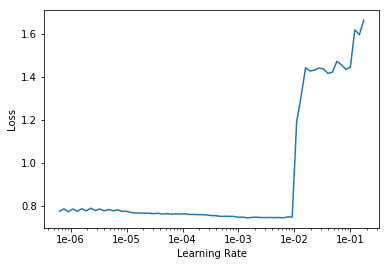

In [46]:
learner.lr_find()
learner.recorder.plot()

In [47]:
learner.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.812902,0.779890,0.520000,00:01
1,0.915797,0.821323,0.480000,00:01
2,0.858090,0.720759,0.480000,00:01
3,0.817884,0.708714,0.480000,00:01


### Questions to Answer

In [ ]:
1. How many tweets about the topic, by person, by party, by state
2. How many positive v. negative tweets by person, by party, by state
3. Analysis of the Democratic candidates on this topic (add the twitter accounts of non-Congress members)